In [4]:
 # Importe make_column_selector
from sklearn.compose import make_column_selector
    # Importe make_column_transformer
from sklearn.compose import make_column_transformer
    # Importe SelectKBest
from sklearn.feature_selection import SelectKBest
    # Importe f_regression
from sklearn.feature_selection import f_regression
    # Importe GridSearchCV
from sklearn.model_selection import GridSearchCV
    # Importe Pipeline
from sklearn.pipeline import Pipeline
    # Importe OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
df_sub_path = "amex-default-prediction/sample_submission.csv"
df_train_path = "amex-default-prediction/train_data.csv"
df_test_path = "amex-default-prediction/test_data.csv"
df_labels_path = "amex-default-prediction/train_labels.csv"

sample_size = 750000
batch_size = 10000

train_reader = pd.read_csv(df_train_path, dtype=str, chunksize=batch_size)
labels_reader = pd.read_csv(df_labels_path, dtype=str, chunksize=batch_size)
#test_reader = pd.read_csv(df_test_path, dtype=str, chunksize=batch_size)


X = train_reader.get_chunk(sample_size)
y = labels_reader.get_chunk(sample_size)
#df_test = test_reader.get_chunk(sample_size)

In [30]:
cont_cols=[]
def limpiezadedatos(df_train,df_labels):
    df_train_Xy = pd.merge(df_train, df_labels, on='customer_ID')
    
    df_train_Xy = df_train_Xy.drop(columns=['S_2'])
    #print(df_train_Xy)
    categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']
    all_cols = list(df_train_Xy.columns)
    cont_cols = list(set(all_cols)-set(categorical_cols))
    cont_cols = cont_cols[:128] + ['target']
    df=df_train_Xy[categorical_cols]
    df_train_Xy = df_train_Xy[cont_cols]
    df_train_Xy['target'] = df_train_Xy['target'].astype('category')
    X,y = df_train_Xy.iloc[:,:-1], df_train_Xy.iloc[:,-1]
    X= X
    X = X.fillna(0)
    return X,y


In [31]:
X,y=limpiezadedatos(X,y)

In [7]:
y=y.astype("float32")

In [8]:
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

In [10]:
X=X.drop("customer_ID",axis=1).astype("float32")

In [11]:
X=minmax_norm(X)


In [ ]:
#from sklearn.feature_selection import SelectKBest, chi2
#X= pd.DataFrame( SelectKBest(chi2, k=64).fit_transform(X, y)).drop_duplicates()
#X.shape

In [12]:
from sklearn.feature_selection import SelectKBest, chi2
selector=SelectKBest(chi2, k=64)
selector.fit(X,y)
X=pd.DataFrame( selector.transform(X))


(750000, 64)

In [44]:
columnas=selector.feature_names_in_

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split((X),(y), test_size=0.2, random_state=123)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

In [20]:
model = Sequential([
    Dense(32, activation='relu', input_shape=([len(X_train.keys())])),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(X_train, y_train,
          batch_size=32, epochs=25,
          validation_data=(X_test,y_test))

Epoch 1/25
18750/18750 [==============================] - 57s 3ms/step - loss: 0.3030 - accuracy: 0.8608 - val_loss: 0.3058 - val_accuracy: 0.8606
Epoch 2/25
18750/18750 [==============================] - 58s 3ms/step - loss: 0.2910 - accuracy: 0.8668 - val_loss: 0.3111 - val_accuracy: 0.8519
Epoch 3/25
18750/18750 [==============================] - 59s 3ms/step - loss: 0.2891 - accuracy: 0.8681 - val_loss: 0.3071 - val_accuracy: 0.8613
Epoch 4/25
18750/18750 [==============================] - 59s 3ms/step - loss: 0.2885 - accuracy: 0.8683 - val_loss: 0.3127 - val_accuracy: 0.8585
Epoch 5/25
18750/18750 [==============================] - 59s 3ms/step - loss: 0.2877 - accuracy: 0.8686 - val_loss: 0.3149 - val_accuracy: 0.8573
Epoch 6/25
18750/18750 [==============================] - 57s 3ms/step - loss: 0.2869 - accuracy: 0.8686 - val_loss: 0.3197 - val_accuracy: 0.8558
Epoch 7/25
18750/18750 [==============================] - 57s 3ms/step - loss: 0.2866 - accuracy: 0.8689 - val_loss: 0

In [22]:
y_pred=model.predict(X_test)
y_pred=pd.DataFrame(y_pred).apply(lambda x : round(x))

y_pred.sample(5)

,0
51487,0.0
35588,0.0
41641,0.0
112799,0.0
19234,0.0


In [23]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test, y_pred)

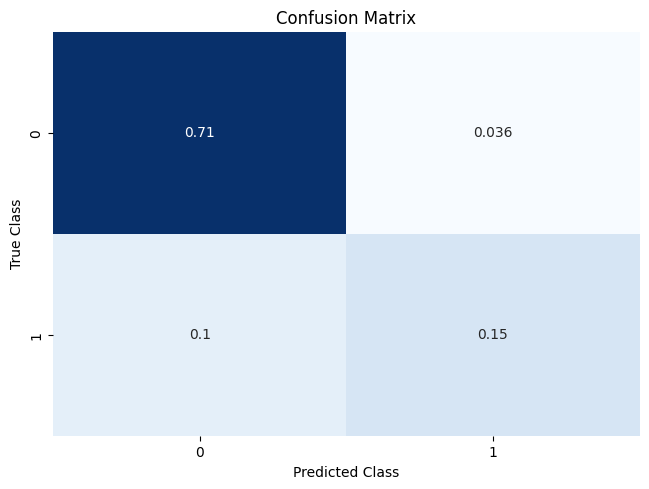

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(matrix, index=[0,1], columns=[0,1])
dataframe=dataframe/len(y_pred)
# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [52]:
# Definimos el tamaño máximo de filas de cada partición (1MM)

# Creamos un objeto iterador 'df_chunk' que contendrá las particiones con 1MM de filas en cada iteración
test_reader = pd.read_csv(df_test_path, dtype=str, chunksize=size)
# Creamos una variable booleana verdadera 'header' para exportar las cabeceras una única vez
header = True

# Ahora vamos a recorrer cada partición, realizar el filtro solicitado, y exportar el resultado a un nuevo CSV
# El atributo mode='a' (APPEND) sirve para no sobreescribir el archivo Resultado.csv en cada iteración, sino para siempre adjuntar los nuevos resultados
# Luego de la 1ra iteración 'header' vuelve a ser falsa para no colocar nuevamente las cabeceras en el CSV final
j=0
for i in test_reader:
    j=j+1
    if j%100==0:
        print(j)
    else:
        print(".",end="")
    df_test=i.fillna(0)
    df_test1 = np.asarray(df_test['customer_ID'])
    df_test = pd.DataFrame( selector.transform(df_test[cont_cols].drop(['customer_ID'],axis=1)))
    df_test=minmax_norm(df_test.astype("float32"))
    prediction = np.round(model.predict(df_test[X_train.columns]))
    #print(df_test1.shape,prediction.shape)
    submission = pd.DataFrame({'customer_ID':df_test1.flatten(),'prediction':prediction.flatten()})
    submission.to_csv('submission6.csv', header=header, mode='a',index = False)
    header = False

.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


100


C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


.

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [8]:
df=pd.read_csv('submission6.csv')
df.columns

Index(['customer_ID', 'prediction'], dtype='object')

In [9]:
df.drop_duplicates(subset=['customer_ID'],inplace=True)
df.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,1.0
9,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0
22,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,1.0
35,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,1.0
48,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.0


In [20]:
df.prediction.unique()

array([0, 1], dtype=int64)

In [12]:
df.to_csv("sub6.csv",index = False)

In [22]:
y.target.unique()

array(['0', '1'], dtype=object)